In [1]:
!pip install fbprophet

## Librerias

In [24]:
import time
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import io, base64, os, json, re, glob
import datetime
from datetime import timedelta
import pandas as pd
import pydata_google_auth
import numpy as np
import altair as alt
alt.renderers.enable()
from IPython.display import HTML

from pandas.plotting import scatter_matrix
sns.set()

from fbprophet import Prophet
import statsmodels.api as sm

## Cargando Datos

In [3]:
path = '/content/drive/My Drive/'
#file = 'SCADA_data_WT2339.csv'
file = 'WT2647.csv'
df_raw = pd.read_csv(path+file,
                   low_memory=False)
df_raw['date_time'] = pd.to_datetime(df_raw['date_time'], format="%Y/%m/%d %H:%M:%S")
df_raw = df_raw.sort_values(by='date_time')
df_raw.tail()

,id,date_time,ld_id,wtc_CurTime_endvalue,wtc_SecAnemo_min,wtc_SecAnemo_max,wtc_SecAnemo_mean,wtc_SecAnemo_stddev,wtc_YawPos_min,wtc_YawPos_max,wtc_YawPos_mean,wtc_YawPos_stddev,wtc_GenRpm_min,wtc_GenRpm_max,wtc_GenRpm_mean,wtc_GenRpm_stddev,wtc_HubLubGr_min,wtc_HubLubGr_max,wtc_HubLubGr_mean,wtc_HubLubGr_stddev,wtc_IceDetec_min,wtc_IceDetec_max,wtc_IceDetec_mean,wtc_IceDetec_stddev,wtc_IMidBa_min,wtc_IMidBa_max,wtc_IMidBa_mean,wtc_IMidBa_stddev,wtc_IMidCa_min,wtc_IMidCa_max,wtc_IMidCa_mean,wtc_IMidCa_stddev,wtc_IMidAa_min,wtc_IMidAa_max,wtc_IMidAa_mean,wtc_IMidAa_stddev,wtc_MainSRpm_min,wtc_MainSRpm_max,wtc_MainSRpm_mean,wtc_MainSRpm_stddev,...,wtc_HydOilTm_max,wtc_HydOilTm_mean,wtc_HydOilTm_stddev,wtc_GFilB1Tm_min,wtc_GFilB1Tm_max,wtc_GFilB1Tm_mean,wtc_GFilB1Tm_stddev,wtc_GFilB2Tm_min,wtc_GFilB2Tm_max,wtc_GFilB2Tm_mean,wtc_GFilB2Tm_stddev,wtc_GFilB3Tm_min,wtc_GFilB3Tm_max,wtc_GFilB3Tm_mean,wtc_GFilB3Tm_stddev,wtc_ReacUTmp_min,wtc_ReacUTmp_max,wtc_ReacUTmp_mean,wtc_ReacUTmp_stddev,wtc_ReacVTmp_min,wtc_ReacVTmp_max,wtc_ReacVTmp_mean,wtc_ReacVTmp_stddev,wtc_ReacWTmp_min,wtc_ReacWTmp_max,wtc_ReacWTmp_mean,wtc_ReacWTmp_stddev,wtc_MainBTmp_min,wtc_MainBTmp_max,wtc_MainBTmp_mean,wtc_MainBTmp_stddev,wtc_MBearHTm_min,wtc_MBearHTm_max,wtc_MBearHTm_mean,wtc_MBearHTm_stddev,wtc_MBearGTm_min,wtc_MBearGTm_max,wtc_MBearGTm_mean,wtc_MBearGTm_stddev,Availability
341512,6393766,2020-06-30 23:30:00,2647,NaN,8.44,10.94,9.86258,0.362654,194.5,194.5,194.500,0.000000e+00,1436.2,1463.7,1449.32,4.06749,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.8,16.2,15.9954,0.061672,...,33.0,32.3712,0.483121,28.0,28.0,28.0,0.0,32.0,32.0,32.0,0.0,27.0,28.0,27.9778,0.147225,47.0,48.0,47.8319,0.373985,42.0,43.0,42.1192,0.324043,41.0,41.0,41.0000,0.000000,45.0,45.0,45.0000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
341513,6393767,2020-06-30 23:40:00,2647,NaN,7.94,10.71,9.41772,0.417045,189.0,194.5,190.182,1.932720e+00,1393.0,1459.5,1441.74,13.34530,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.3,16.1,15.9114,0.153377,...,36.0,34.4878,0.593789,28.0,28.0,28.0,0.0,32.0,32.0,32.0,0.0,27.0,28.0,27.8533,0.353807,46.0,48.0,47.0898,0.318416,41.0,42.0,41.7292,0.444390,40.0,41.0,40.4216,0.493820,45.0,45.0,45.0000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
341514,6393768,2020-06-30 23:50:00,2647,NaN,8.51,10.97,9.68928,0.390043,189.0,192.0,190.752,1.442760e+00,1425.7,1462.5,1448.36,5.71256,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.6,16.2,15.9861,0.074639,...,36.0,34.5626,1.188670,28.0,28.0,28.0,0.0,32.0,32.0,32.0,0.0,27.0,28.0,27.1111,0.314215,46.0,47.0,46.2805,0.449243,41.0,42.0,41.0018,0.042388,39.0,40.0,39.9287,0.257325,45.0,46.0,45.0905,0.286968,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
341515,6393769,2020-07-01 00:00:00,2647,NaN,7.88,11.03,9.50106,0.454803,192.0,192.0,192.000,2.842170e-14,1408.4,1464.2,1443.81,9.81996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.5,16.2,15.9348,0.114088,...,36.0,34.9359,0.718405,28.0,28.0,28.0,0.0,32.0,32.0,32.0,0.0,27.0,27.0,27.0000,0.000000,45.0,46.0,45.8906,0.312120,40.0,41.0,40.6966,0.459712,39.0,40.0,39.0457,0.208906,45.0,46.0,45.6649,0.472020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
341516,6393770,2020-07-01 00:10:00,2647,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,36.0,34.0000,1.137930,28.0,28.0,28.0,0.0,32.0,32.0,32.0,0.0,27.0,27.0,27.0000,0.000000,45.0,46.0,45.1145,0.318418,39.0,41.0,40.0289,0.175119,38.0,39.0,38.8345,0.371616,45.0,46.0,45.9825,0.131125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [4]:
df_raw.head()

,id,date_time,ld_id,wtc_CurTime_endvalue,wtc_SecAnemo_min,wtc_SecAnemo_max,wtc_SecAnemo_mean,wtc_SecAnemo_stddev,wtc_YawPos_min,wtc_YawPos_max,wtc_YawPos_mean,wtc_YawPos_stddev,wtc_GenRpm_min,wtc_GenRpm_max,wtc_GenRpm_mean,wtc_GenRpm_stddev,wtc_HubLubGr_min,wtc_HubLubGr_max,wtc_HubLubGr_mean,wtc_HubLubGr_stddev,wtc_IceDetec_min,wtc_IceDetec_max,wtc_IceDetec_mean,wtc_IceDetec_stddev,wtc_IMidBa_min,wtc_IMidBa_max,wtc_IMidBa_mean,wtc_IMidBa_stddev,wtc_IMidCa_min,wtc_IMidCa_max,wtc_IMidCa_mean,wtc_IMidCa_stddev,wtc_IMidAa_min,wtc_IMidAa_max,wtc_IMidAa_mean,wtc_IMidAa_stddev,wtc_MainSRpm_min,wtc_MainSRpm_max,wtc_MainSRpm_mean,wtc_MainSRpm_stddev,...,wtc_HydOilTm_max,wtc_HydOilTm_mean,wtc_HydOilTm_stddev,wtc_GFilB1Tm_min,wtc_GFilB1Tm_max,wtc_GFilB1Tm_mean,wtc_GFilB1Tm_stddev,wtc_GFilB2Tm_min,wtc_GFilB2Tm_max,wtc_GFilB2Tm_mean,wtc_GFilB2Tm_stddev,wtc_GFilB3Tm_min,wtc_GFilB3Tm_max,wtc_GFilB3Tm_mean,wtc_GFilB3Tm_stddev,wtc_ReacUTmp_min,wtc_ReacUTmp_max,wtc_ReacUTmp_mean,wtc_ReacUTmp_stddev,wtc_ReacVTmp_min,wtc_ReacVTmp_max,wtc_ReacVTmp_mean,wtc_ReacVTmp_stddev,wtc_ReacWTmp_min,wtc_ReacWTmp_max,wtc_ReacWTmp_mean,wtc_ReacWTmp_stddev,wtc_MainBTmp_min,wtc_MainBTmp_max,wtc_MainBTmp_mean,wtc_MainBTmp_stddev,wtc_MBearHTm_min,wtc_MBearHTm_max,wtc_MBearHTm_mean,wtc_MBearHTm_stddev,wtc_MBearGTm_min,wtc_MBearGTm_max,wtc_MBearGTm_mean,wtc_MBearGTm_stddev,Availability
0,5,2014-01-01 01:00:00,2647,NaN,7.0,10.6,8.77420,0.575722,142.4,145.2,142.853,0.999360,1415.0,1485.8,1447.98,11.92710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.6,16.4,15.9814,0.136938,...,36.0,35.4597,0.498375,13.0,13.0,13.0000,0.000000,16.0,17.0,16.0790,0.269739,11.0,13.0,11.9657,0.191071,41.0,42.0,41.9223,0.267751,36.0,37.0,36.6956,0.460132,35.0,36.0,35.4570,0.498145,35.0,35.0,35.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,23,2014-01-01 01:10:00,2647,NaN,6.7,10.8,8.74425,0.633092,139.9,145.1,142.106,1.256810,1419.6,1484.8,1447.29,11.24940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.6,16.4,15.9741,0.130385,...,36.0,35.4939,0.499963,13.0,14.0,13.4481,0.497296,16.0,18.0,16.6869,0.606319,11.0,14.0,12.5851,0.795229,41.0,42.0,41.2551,0.435889,35.0,37.0,36.0400,0.206522,34.0,35.0,34.9917,0.090454,35.0,35.0,35.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,41,2014-01-01 01:20:00,2647,NaN,5.1,10.6,8.47744,0.721200,138.4,140.0,138.540,0.397215,1394.1,1486.4,1445.56,14.02220,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.3,16.4,15.9547,0.159573,...,36.0,35.4810,0.499638,13.0,13.0,13.0000,0.000000,16.0,16.0,16.0000,0.000000,11.0,12.0,11.8598,0.347229,40.0,41.0,40.5277,0.499230,34.0,36.0,35.3009,0.473349,33.0,35.0,33.9638,0.459991,35.0,35.0,35.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,59,2014-01-01 01:30:00,2647,NaN,6.7,10.6,8.62984,0.568890,138.4,139.6,139.395,0.405489,1414.9,1477.9,1448.20,9.72203,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.5,16.3,15.9836,0.114708,...,36.0,35.6104,0.487660,13.0,14.0,13.3407,0.473945,16.0,18.0,16.5354,0.573103,11.0,14.0,12.4535,0.828475,39.0,40.0,39.5989,0.490128,34.0,35.0,34.4257,0.494454,33.0,34.0,33.0017,0.041196,35.0,35.0,35.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,77,2014-01-01 01:40:00,2647,NaN,5.9,10.1,8.41628,0.600944,139.6,139.7,139.602,0.014499,1394.9,1478.7,1446.39,12.39360,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.4,16.4,15.9645,0.142770,...,36.0,35.4895,0.499890,13.0,13.0,13.0000,0.000000,16.0,16.0,16.0000,0.000000,11.0,12.0,11.3238,0.467931,38.0,40.0,38.8132,0.400327,33.0,34.0,33.7078,0.454774,32.0,33.0,32.3309,0.470531,35.0,35.0,35.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [5]:
print(list(df_raw.columns))

['id', 'date_time', 'ld_id', 'wtc_CurTime_endvalue', 'wtc_SecAnemo_min', 'wtc_SecAnemo_max', 'wtc_SecAnemo_mean', 'wtc_SecAnemo_stddev', 'wtc_YawPos_min', 'wtc_YawPos_max', 'wtc_YawPos_mean', 'wtc_YawPos_stddev', 'wtc_GenRpm_min', 'wtc_GenRpm_max', 'wtc_GenRpm_mean', 'wtc_GenRpm_stddev', 'wtc_HubLubGr_min', 'wtc_HubLubGr_max', 'wtc_HubLubGr_mean', 'wtc_HubLubGr_stddev', 'wtc_IceDetec_min', 'wtc_IceDetec_max', 'wtc_IceDetec_mean', 'wtc_IceDetec_stddev', 'wtc_IMidBa_min', 'wtc_IMidBa_max', 'wtc_IMidBa_mean', 'wtc_IMidBa_stddev', 'wtc_IMidCa_min', 'wtc_IMidCa_max', 'wtc_IMidCa_mean', 'wtc_IMidCa_stddev', 'wtc_IMidAa_min', 'wtc_IMidAa_max', 'wtc_IMidAa_mean', 'wtc_IMidAa_stddev', 'wtc_MainSRpm_min', 'wtc_MainSRpm_max', 'wtc_MainSRpm_mean', 'wtc_MainSRpm_stddev', 'wtc_PitchRef_min', 'wtc_PitchRef_max', 'wtc_PitchRef_mean', 'wtc_PitchRef_stddev', 'wtc_PitchRef_BladeA_min', 'wtc_PitchRef_BladeA_max', 'wtc_PitchRef_BladeA_mean', 'wtc_PitchRef_BladeA_stddev', 'wtc_PitchRef_BladeB_min', 'wtc_Pit

## Graficas
### Temperatura Eje Lento

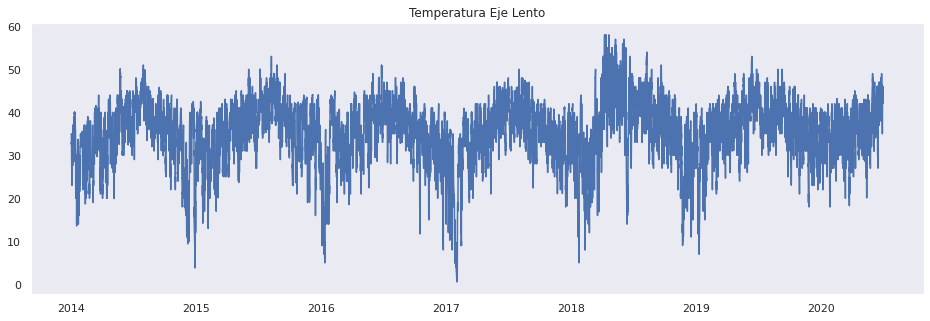

In [6]:
plt.subplots(1, figsize = (16, 5))
plt.grid()
plt.title('Temperatura Eje Lento')
#plt.plot(df_raw['TempEjeLento_1'].rolling(window=150).median())
plt.plot(df_raw['date_time'],df_raw['wtc_MainBTmp_mean'])
plt.show()

### Variables Exógenas

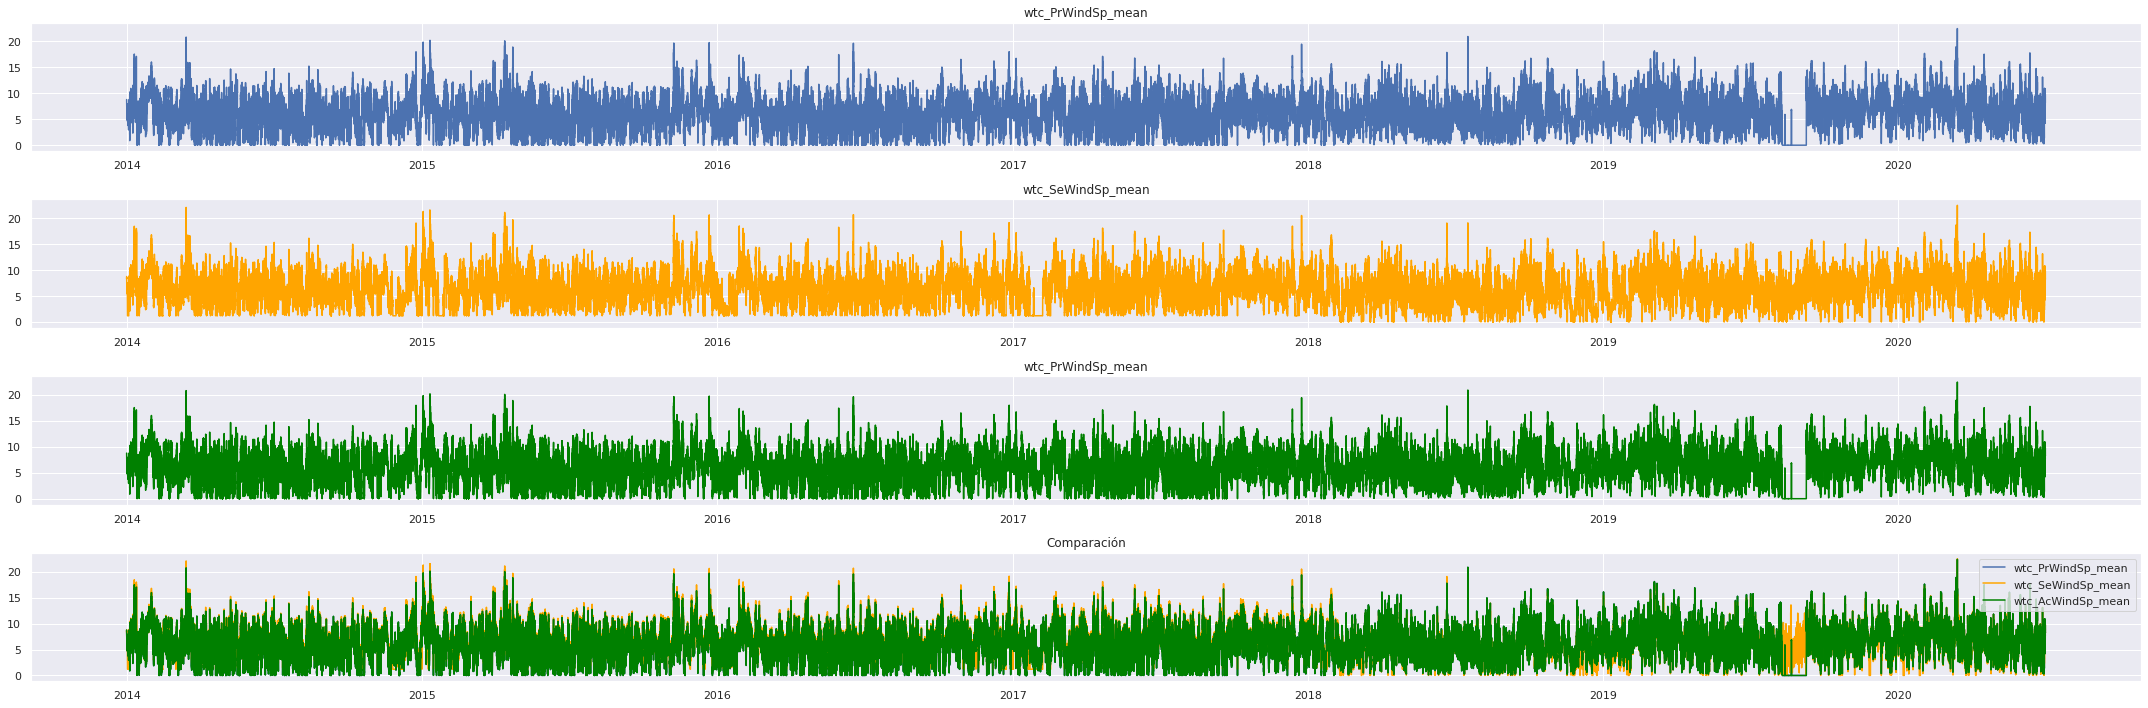

In [7]:
df_exogenas = df_raw[['wtc_PrWindSp_mean','wtc_SeWindSp_mean','wtc_AcWindSp_mean']]
plt.figure(figsize=(30,10))

plt.subplot(411)
plt.title('wtc_PrWindSp_mean')
plt.plot(df_raw['date_time'],df_exogenas.wtc_PrWindSp_mean)

plt.subplot(412)
plt.title('wtc_SeWindSp_mean')
plt.plot(df_raw['date_time'],df_exogenas.wtc_SeWindSp_mean,color='orange')

plt.subplot(413)
plt.title('wtc_PrWindSp_mean')
plt.plot(df_raw['date_time'],df_exogenas.wtc_PrWindSp_mean,color='green')


plt.subplot(414)
plt.title('Comparación')
plt.plot(df_raw['date_time'],df_exogenas.wtc_PrWindSp_mean,label='wtc_PrWindSp_mean')
plt.plot(df_raw['date_time'],df_exogenas.wtc_SeWindSp_mean,color='orange',label='wtc_SeWindSp_mean')
plt.plot(df_raw['date_time'],df_exogenas.wtc_PrWindSp_mean,color='green',label='wtc_AcWindSp_mean')
plt.legend()
plt.tight_layout()
plt.show()

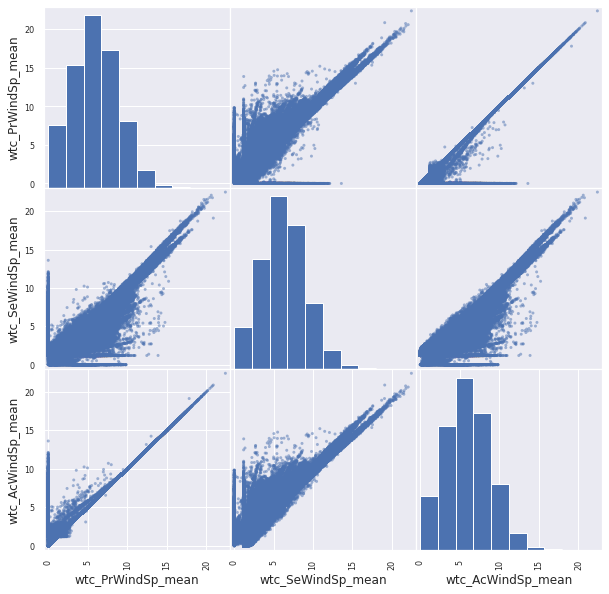

In [8]:
SM = scatter_matrix(df_exogenas,figsize=(10,10))

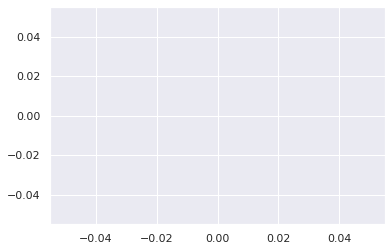

In [9]:
df_raw['wtc_TetAnemo_mean'].plot()

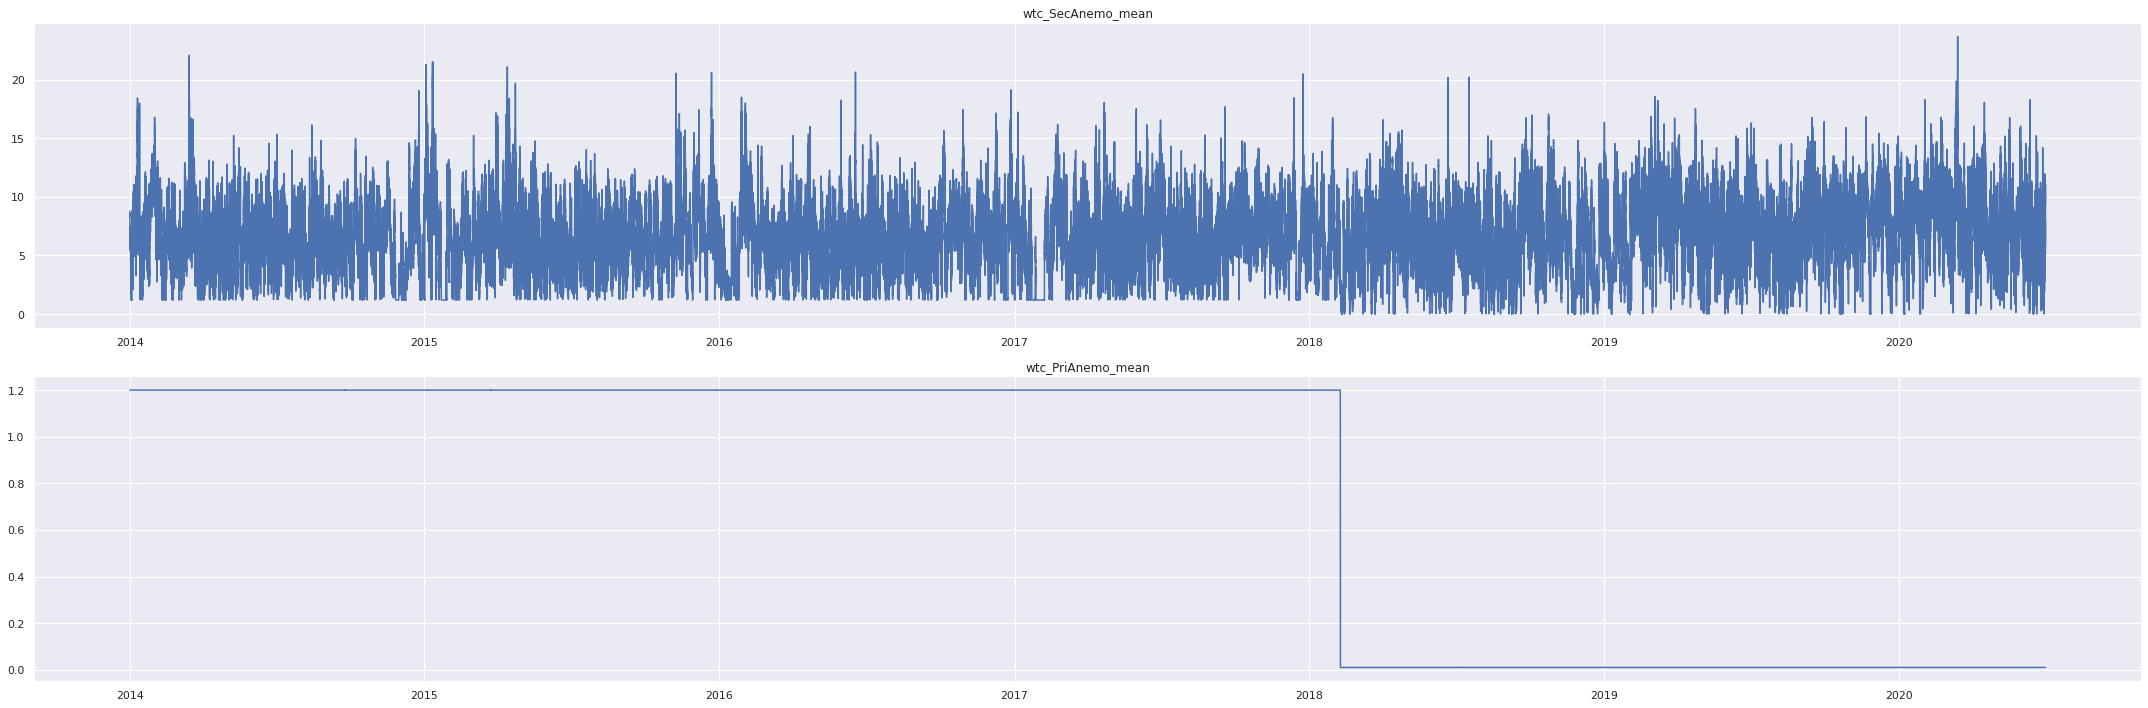

In [10]:
df_exogenas2 = df_raw[['wtc_SecAnemo_mean','wtc_PriAnemo_mean']]
plt.figure(figsize=(30,10))

plt.subplot(211)
plt.title('wtc_SecAnemo_mean')
plt.plot(df_raw['date_time'],df_exogenas2.wtc_SecAnemo_mean)

plt.subplot(212)
plt.title('wtc_PriAnemo_mean')
plt.plot(df_raw['date_time'],df_exogenas2.wtc_PriAnemo_mean)

plt.tight_layout()
plt.show()

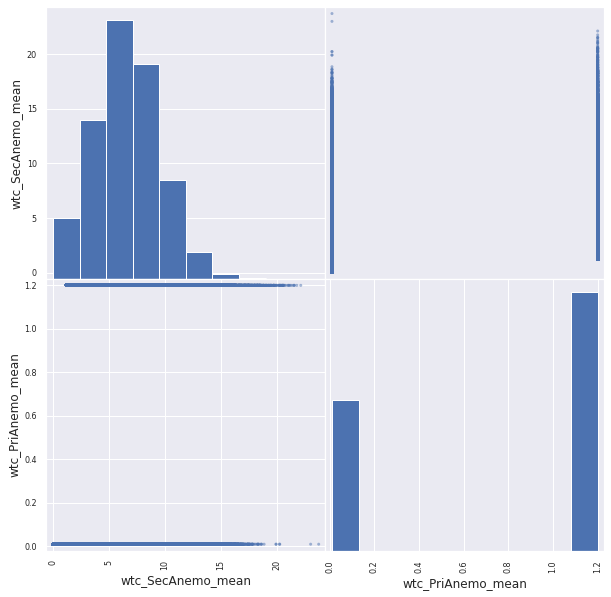

In [11]:
SM = scatter_matrix(df_exogenas2,figsize=(10,10))

## Creando Modelo

In [12]:
train_dataset = df_raw[['date_time','wtc_MainBTmp_mean','wtc_PrWindSp_mean','wtc_AmbieTmp_mean']]
train_dataset.columns = ['ds', 'y','wtc_PrWindSp_mean','wtc_AmbieTmp_mean']
train_dataset=train_dataset.dropna()
train_dataset.head()

,ds,y,wtc_PrWindSp_mean,wtc_AmbieTmp_mean
0,2014-01-01 01:00:00,35.0,8.75971,-1.94002
1,2014-01-01 01:10:00,35.0,8.68376,-1.99487
2,2014-01-01 01:20:00,35.0,8.46292,-2.00000
3,2014-01-01 01:30:00,35.0,8.70971,-2.00000
4,2014-01-01 01:40:00,35.0,8.35981,-2.00000


In [13]:
print('Total de muestras en el tiempo: ',train_dataset.shape[0])

Total de muestras en el tiempo:  341506


In [14]:
date = '2017-12-11'
date_fail = '2019-12-12'
data_sano = train_dataset[(train_dataset['ds'] < date)]

In [15]:
data_prefallo = train_dataset[(train_dataset['ds'] > date)]
data_prefallo = data_prefallo[(data_prefallo['ds']<date_fail)]

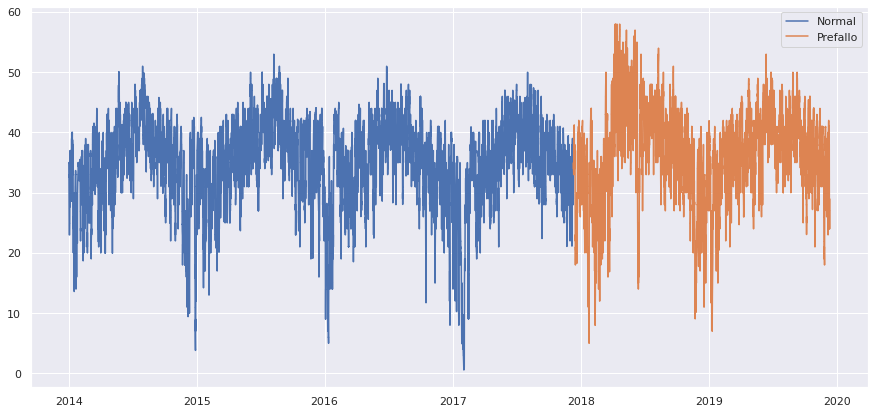

In [16]:
plt.figure(figsize=(15,7))
plt.plot(data_sano['ds'],data_sano['y'],label='Normal')
plt.plot(data_prefallo['ds'],data_prefallo['y'],label='Prefallo')
plt.legend()
plt.show()

### Modelo Prophet

Displaying Prophet plot


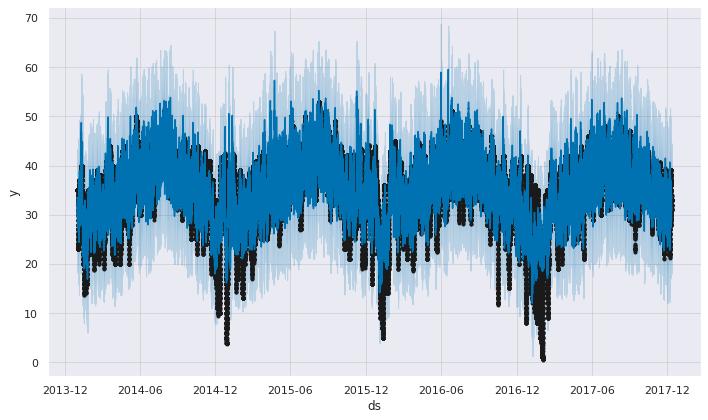

In [17]:
def fit_predict_model(dataframe, interval_width = 0.99, changepoint_range = 0.8):
    m = Prophet(daily_seasonality = False, yearly_seasonality = False, weekly_seasonality = False,
                seasonality_mode = 'multiplicative', 
                interval_width = interval_width,
                changepoint_range = changepoint_range)
    m.add_regressor('wtc_PrWindSp_mean')
    m.add_regressor('wtc_AmbieTmp_mean')
    m = m.fit(dataframe)
    
    forecast = m.predict(dataframe)
    forecast['fact'] = dataframe['y'].reset_index(drop = True)
    print('Displaying Prophet plot')
    fig1 = m.plot(forecast)
    return forecast

pred = fit_predict_model(data_sano)

In [18]:
def detect_anomalies(forecast):
    forecasted = forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()
    #forecast['fact'] = df['y']

    forecasted['anomaly'] = 0
    forecasted.loc[forecasted['fact'] > forecasted['yhat_upper'], 'anomaly'] = 1
    forecasted.loc[forecasted['fact'] < forecasted['yhat_lower'], 'anomaly'] = -1

    #anomaly importances
    forecasted['importance'] = 0
    forecasted.loc[forecasted['anomaly'] ==1, 'importance'] = \
        (forecasted['fact'] - forecasted['yhat_upper'])/forecast['fact']
    forecasted.loc[forecasted['anomaly'] ==-1, 'importance'] = \
        (forecasted['yhat_lower'] - forecasted['fact'])/forecast['fact']
    
    return forecasted

pred = detect_anomalies(pred)

In [19]:
pred.head()

,ds,trend,yhat,yhat_lower,yhat_upper,fact,anomaly,importance
0,2014-01-01 01:00:00,34.976504,33.512231,23.870126,43.195187,35.0,0,0.0
1,2014-01-01 01:10:00,34.976395,33.375753,22.865034,43.335949,35.0,0,0.0
2,2014-01-01 01:20:00,34.976287,33.064748,23.371253,43.406095,35.0,0,0.0
3,2014-01-01 01:30:00,34.976178,33.408898,23.915039,43.127765,35.0,0,0.0
4,2014-01-01 01:40:00,34.976069,32.920713,24.373426,42.049953,35.0,0,0.0


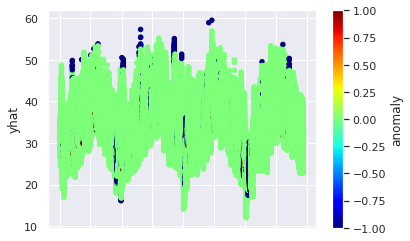

In [41]:
def plot_anomalies(forecasted):
    #plt.plot(forecasted.ds,forecasted.yhat,colo)
    #plt.plot(forecasted.ds,forecasted.trend)
    #plt.plot(forecasted.ds,forecasted.yhat_lower)
    forecasted.plot.scatter('ds', 'yhat', c='anomaly',colormap='jet')
plot_anomalies(pred)

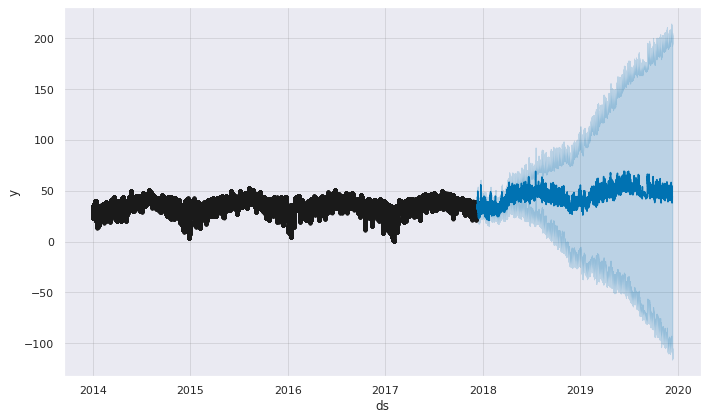

In [ ]:
forecast=prophet_basic.predict(data_prefallo.drop(columns="y"))
fig1 =prophet_basic.plot(forecast)

In [ ]:
fig1 = prophet_basic.plot_components(forecast)

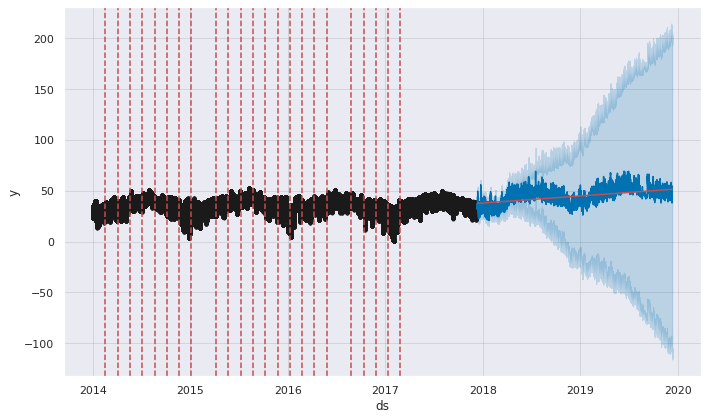

In [ ]:
from fbprophet.plot import add_changepoints_to_plot
fig = prophet_basic.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet_basic, forecast)

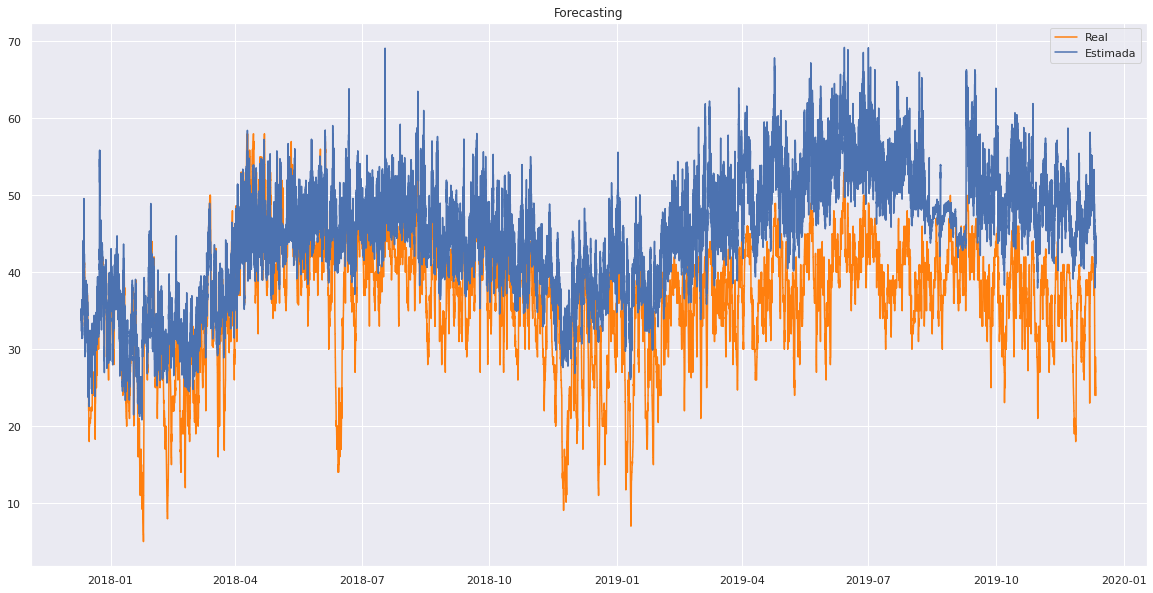

In [ ]:
plt.figure(figsize=(20,10))
#plt.plot(forecast['ds'],forecast['yhat_lower'],'-r',label='Confianza')
#plt.plot(forecast['ds'],forecast['yhat_upper'],'-r')
plt.plot(data_prefallo['ds'],data_prefallo['y'],'tab:orange',label='Real')
plt.plot(forecast['ds'],forecast['yhat'],'b',label='Estimada')
#plt.plot(data_1['ds'],data_1['y'],'c')
plt.legend()
plt.title('Forecasting')
plt.show()

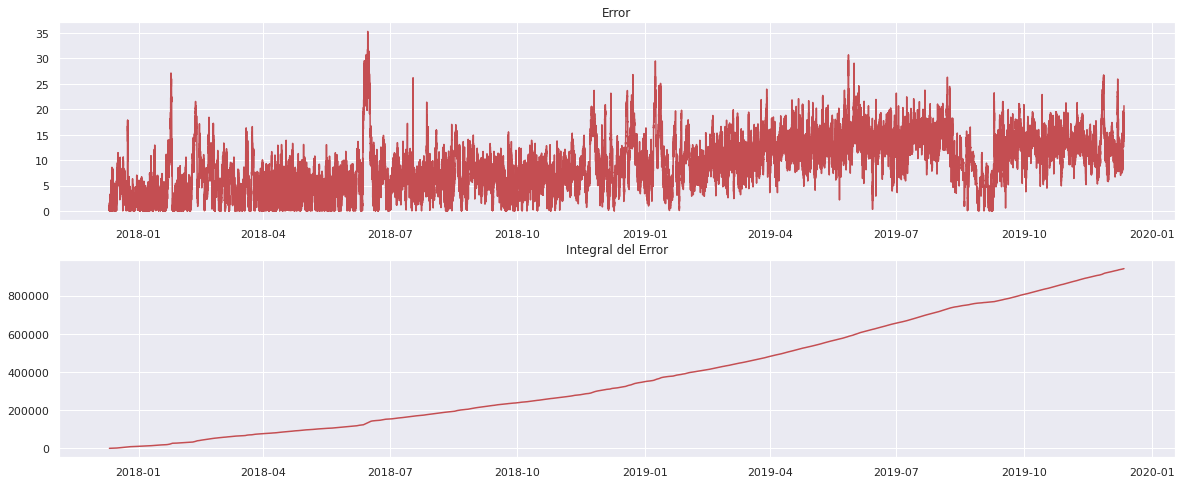

In [ ]:
import numpy as np
forecast['error']= data_prefallo['y']-forecast['yhat']
forecast['y_true'] = data_prefallo['y'].values
forecast['error'] = forecast['y_true']-forecast['yhat']

plt.figure(figsize=(20,8))
plt.subplot(211)
plt.title('Error')
plt.plot(forecast['ds'],forecast['error'].abs(),'r')
plt.subplot(212)
plt.title('Integral del Error')
plt.plot(forecast['ds'],forecast['error'].abs().cumsum(),'r')
plt.show()

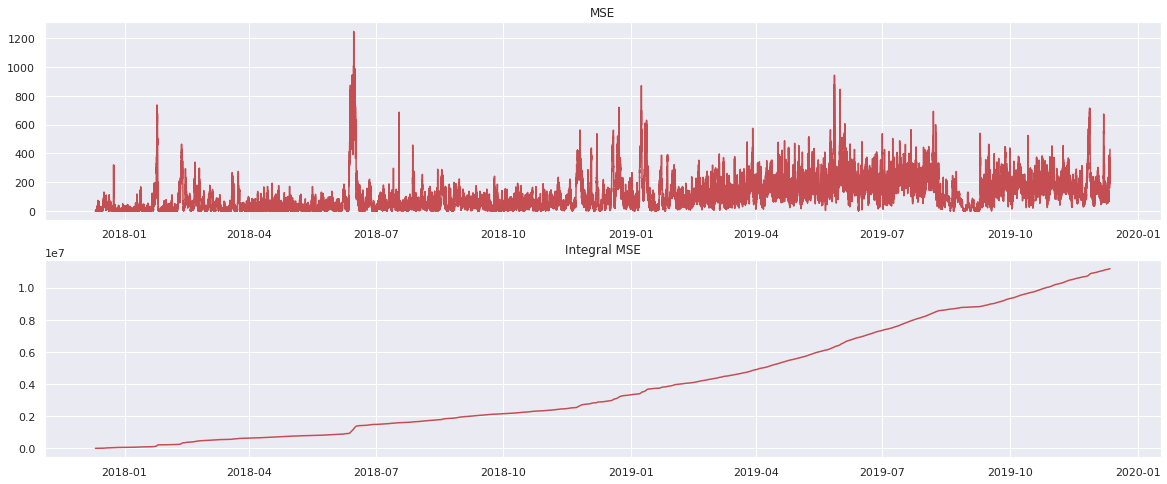

In [ ]:
signal = forecast['error']**2
plt.figure(figsize=(20,8))
plt.subplot(211)
plt.plot(forecast['ds'],signal,'r')
plt.title('MSE')
plt.subplot(212)
signal=forecast['error']**2
plt.plot(forecast['ds'],signal.cumsum(),'r')
plt.title('Integral MSE')
plt.show()